In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import utils as utils

sns.set_color_codes("muted")


# 1. Cleaning

In [2]:

df_vehicles = pd.read_csv('./data/vehicles.csv')


In [3]:
df_vehicles.shape


(426880, 26)

## Chopping Price

In [4]:
_, _, lower = utils.cutIQR(df_vehicles, 'price', q1=0.1, r = 0)

_, upper, _ = utils.cutIQR(df_vehicles, 'price', q2=0.95, r = 0)

print('Price: ', lower, upper)


Price:  500.0 44500.0


In [5]:
# invalid prices 
df_vehicles = df_vehicles[df_vehicles['price'] > lower]

# chopping
df_vehicles.loc[df_vehicles['price'] > upper, 'price'] = upper

# or remove
# df_vehicles = df_vehicles[df_vehicles['price'] <= upper]


In [6]:
df_vehicles.shape


(383765, 26)

## Chopping odometer

In [7]:
_, upper_inner_odometer, _ = utils.cutIQR(df_vehicles, 'odometer', q2=0.95, r = 0)

df_vehicles.loc[ df_vehicles['odometer'] > upper_inner_odometer, 'odometer' ] = upper_inner_odometer

print('Odometer: (0', upper_inner_odometer, ')')


Odometer: (0 206000.0 )


In [8]:
df_vehicles.shape


(383765, 26)

<AxesSubplot:xlabel='odometer', ylabel='price'>

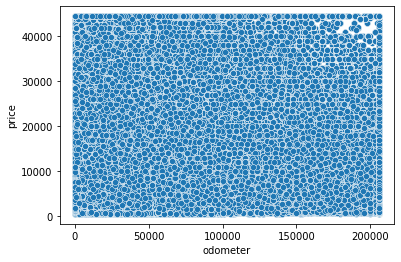

In [9]:
sns.scatterplot(x="odometer", y="price", data=df_vehicles)


<AxesSubplot:xlabel='year', ylabel='price'>

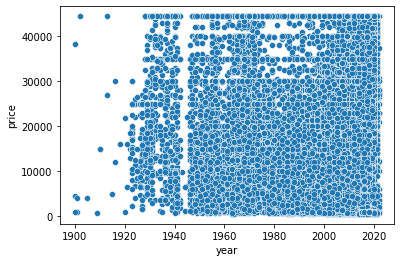

In [10]:
sns.scatterplot(x="year", y="price", data=df_vehicles)


## Remove old car

Earlier than 1920, they will increase uncertainty to prediction


In [11]:
df_vehicles = df_vehicles[df_vehicles['year'] > 1920]


In [75]:
df_vehicles.shape


(382575, 26)

<AxesSubplot:xlabel='year', ylabel='price'>

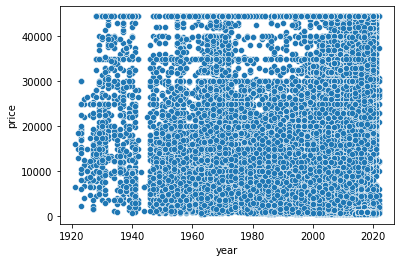

In [12]:
sns.scatterplot(x="year", y="price", data=df_vehicles)


TODO:

- remove rows with missing few values?

- remove insufficient records?


In [13]:
# df_vehicles['year'].isna()


## Split Train Test Set

In [14]:
from sklearn.model_selection import train_test_split

X = df_vehicles.drop('price', axis=1)
y = df_vehicles['price']

X_train_raw, X_test_raw, y_train_raw, y_test_raw  = train_test_split(X, y, test_size=0.2, random_state=40)


In [15]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape


((306060, 25), (306060,), (76515, 25), (76515,))

# 2. Pipeline - Pre-processing & Feature Engineering


Useless columns

Zeo-value columns

Missing Values

Categorical Variables
- Onehot

Feature Enginering



In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class selectColumnTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer to select columns
    """
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X):
        return X[self.columns]
    
    def fit(self, X, y=None):
        return self


class dropAllZeroColumnTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer to drop all-zero columns
    """
    def transform(self, X):
        empty_columns = X.columns[X.isnull().all(axis=0)]
        return X.drop(empty_columns, axis=1)
        
    def fit(self, X, y=None):
        return self

    
class dropUselessColumnsTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer to drop useless columns
    """
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X):
        return X.drop(self.columns, axis=1)
        
    def fit(self, X, y=None):
        return self



In [17]:
cat_attrs = [
    'manufacturer', 'condition', 'cylinders', 
    'fuel', 'title_status', 'transmission',
    'drive', 'type', 'paint_color'  
]

useless_columns = [
    # irrelevant
    'id', 'url', 'region_url', 'image_url', 'posting_date', 'VIN',
    
    # too many missing values
    'size',

    # redudant factors
    'region', 'lat', 'long', 'state',
    
    # maybe useful, need NLP techniques to extract 'description'
    'description', # 'model'
] 

country_manufacture_mapping = {
    'USA': [
        'chevrolet', 'jeep',
        'tesla', 'buick', 'ford', 'gmc', 'ram',
        'lincoln','dodge','chrysler', 'cadillac', 'pontiac', 'mercury', 'saturn', 'harley-davidson'
    ],
    'Japan': [
        'toyota', 
        'acura', 'nissan','infiniti', 'lexus', 
        'honda', 'mitsubishi', 'datsun', 'subaru', 'mazda'
    ],
    'Germany': [
        'mercedes-benz',
        'bmw', 'audi', 'porsche', 
        'volkswagen' 
    ],
    'UK': [
        'aston-martin', 
        'rover', 'jaguar',  
        'mini', 'land-rover', 'morgan', 'land rover'
    ],
    'Italy': [
        'ferrari', 
        'alfa-romeo',
        'fiat', 
    ],
    'Korea': ['hyundai', 'kia'],
    'Sweden': ['volvo'],
}

cond_map = {
    'poor': [ 'salvage' ],
    'fair': [ 'fair' ],
    'good': [ 'good', 'excellent', 'like new', 'new']
}

In [18]:
class categoryAddFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    generate more features from category variables
    """
    def transform(self, X):
        df = pd.DataFrame(X, columns=cat_attrs)

        
        # manufacturer
        for country, manufactures in country_manufacture_mapping.items():
            df.loc[df['manufacturer'].isin(manufactures), 'manu_country'] = country
  

        # condition
        for quality, cond_list in cond_map.items():
            df.loc[df['condition'].isin(cond_list), 'cond_group'] = quality

            
            
        # cylinders - do nothing
        
        
        # fuel
        df.loc[df['fuel'].isin([ 'diesel' ]), 'fuel_group'] = 'diesel'
        df.loc[df['fuel'].isin(['gas', 'other' ]), 'fuel_group'] = 'gas'
        df.loc[df['fuel'].isin(['electric' ]), 'fuel_group'] = 'electric'
        df.loc[df['fuel'].isin(['hybrid' ]), 'fuel_group'] = 'hybrid'
        df.loc[df['fuel'].isna(), 'fuel_group'] = 'hybrid'
        
 
        # title_status
        df.loc[~df['title_status'].isin([ 'clean' ]), 'tt_status_group'] = 'normal'
        df.loc[df['title_status'].isin([ 'clean' ]), 'tt_status_group'] = 'clean'

        
        # transmission
        df.loc[df['transmission'].isna(), 'transmission'] = 'other'
        
        
        # paint_color
        df.loc[df['paint_color'].isin(['white', 'black', 'silver' ]), 'paint_color_group'] = 'popular'
        df.loc[df['paint_color'].isna(), 'paint_color_group'] = 'popular'
        df.loc[~df['paint_color'].isin(['white', 'black', 'silver' ]), 'paint_color_group'] = 'common'
    
        # drive - do nothing
        
        
        # type - do nothing

        
        return df.drop([
            'manufacturer', 'condition', 'fuel', 'title_status', 'paint_color'
        ], axis=1)
  
    def fit(self, X, y=None):
        return self
    

In [19]:
class imputeOdometerYearTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X):
        df = pd.DataFrame(X, columns=['year', 'model', 'odometer', 'condition'])

        # 1. odometer
        df['condition_nan'] = df['condition'].fillna('missing')
        df['odometer'] = df.groupby(['condition_nan'])['odometer'].apply(lambda x: x.fillna(x.median()))
        # default 
        df['odometer'].fillna(df['odometer'].median(), inplace=True)

        # 2. year
        df['model_nan'] = df['model'].fillna('missing')        
        df['year'] = df.groupby(['model_nan'])['year'].apply(lambda x: x.fillna(x.mean()))
        # default 
        df['year'].fillna(df['year'].mean(), inplace=True)

        return df[['year', 'odometer']]

    def fit(self, X, y=None):
        return self


## 4. Model Selection

- Linear Regression

- Decision Tree

- KNN

- Random Forest

- GBoot

- XGBoost
   


In [20]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler

num_pipeline = Pipeline([
   ('num_imputer', imputeOdometerYearTransformer()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('add_feature', categoryAddFeatureTransformer()),
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_pipeline = make_pipeline(
    dropAllZeroColumnTransformer(), # county
    dropUselessColumnsTransformer(useless_columns),
    ColumnTransformer([
        ('num', num_pipeline, ['year', 'model', 'odometer', 'condition']), # drop 'model' here
        ('cat', cat_pipeline, cat_attrs)
    ])
)


In [21]:
X_train = full_pipeline.fit_transform(X_train_raw)
y_train = y_train_raw

X_train.shape, y_train_raw.shape


((306060, 52), (306060,))

In [22]:
X_test = full_pipeline.fit_transform(X_test_raw)
y_test = y_test_raw

X_test.shape, y_test.shape


((76515, 52), (76515,))

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [25]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    RandomForestRegressor(random_state=42, n_estimators=50, max_depth=8),
    GradientBoostingRegressor(),
    # XGBRegressor()
]

model_names = [
    'Linear Regression', 
    'Decision Tree', 
    'KNN',
    'Random Forest', 
    'GBoost',
    # "XGBoost"
]

In [26]:
r2_score_test = []
r2_score_train = []
rmse_test = []
mse_test = []
rmse_mean = []
rmse_std = []

for idx, model in enumerate(models):
    model_ = model.fit(X_train, y_train)
    
    y_train_pred = model_.predict(X_train)
    y_test_pred = model_.predict(X_test)
    
    r2_train_ = model_.score(X_train, y_train)
    r2_score_train.append(r2_train_)
    
    r2_test_ = model_.score(X_test, y_test)
    r2_score_test.append(r2_test_)

    rmse_test_ = mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_test.append(rmse_test_)
    
    mse_test_ = mean_squared_error(y_test, y_test_pred)
    mse_test.append(mse_test_)
    
    print(model_names[idx], ' done')
    
    
result = pd.DataFrame(
    list(zip(r2_score_test, r2_score_train)), 
    columns=["r2_score_test", "r2_score_train"]
)
result["rmse_test"] = rmse_test
result["mse_test"] = mse_test
result["model"] = model_names

result


Linear Regression  done
Decision Tree  done
KNN  done
Random Forest  done
GBoost  done


,r2_score_test,r2_score_train,rmse_test,mse_test,model
0,0.616358,0.617394,7803.028204,6.088725e+07,Linear Regression
1,0.756425,0.995385,6217.505068,3.865737e+07,Decision Tree
2,0.835299,0.896634,5112.672565,2.613942e+07,KNN
3,0.724013,0.726973,6618.273453,4.380154e+07,Random Forest
4,0.744276,0.743703,6370.679377,4.058556e+07,GBoost


## Cross-validation

In [27]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(random_state=42, n_estimators=50, max_depth=8),
    GradientBoostingRegressor(),
    # XGBRegressor()
]

model_names = [
    'Linear Regression', 
    'Decision Tree', 
    'Random Forest', 
    'GBoost',
    # "XGBoost"
]
rmse_mean = []
rmse_std = []
for idx, model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

    rmse = np.sqrt(-scores)
    rmse_mean.append(rmse.mean())
    rmse_std.append(rmse.std())

    print(model_names[idx], ' done')

result = pd.DataFrame(
    list(zip(rmse_mean, rmse_std)), 
    columns=["rmse_mean", "rmse_std"]
)
result["model"] = model_names

result


Linear Regression  done
Decision Tree  done
Random Forest  done
GBoost  done


,rmse_mean,rmse_std,model
0,7796.325793,25.800061,Linear Regression
1,5706.648281,34.076900,Decision Tree
2,6587.066903,21.655049,Random Forest
3,6403.916551,28.374645,GBoost


# 5. Fine-Tuning

Promising models are decision tree, random forest, and gboost

In [42]:
param_grid = {
    'max_depth': np.arange(2, 14, 2),
    'min_samples_leaf': np.arange(10, 20),
}


In [43]:
decision_tree_reg = DecisionTreeRegressor()

grid_search = GridSearchCV(decision_tree_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error', return_train_score=False)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12]),
                         'min_samples_leaf': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             scoring='neg_mean_squared_error')

In [45]:
cvres = grid_search.cv_results_

cvres.keys()


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [49]:

for score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(params, -score)


{'max_depth': 2, 'min_samples_leaf': 10} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 11} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 12} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 13} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 14} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 15} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 16} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 17} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 18} 87291924.09535265
{'max_depth': 2, 'min_samples_leaf': 19} 87291924.09535265
{'max_depth': 4, 'min_samples_leaf': 10} 66290762.11601497
{'max_depth': 4, 'min_samples_leaf': 11} 66290762.11601497
{'max_depth': 4, 'min_samples_leaf': 12} 66290762.11601497
{'max_depth': 4, 'min_samples_leaf': 13} 66290762.11601497
{'max_depth': 4, 'min_samples_leaf': 14} 66290762.11601497
{'max_depth': 4, 'min_samples_leaf': 15} 66290762.11601497
{'max_depth': 4, 'min_samples_leaf': 16} 66290762.116014

In [47]:
grid_search.best_estimator_


DecisionTreeRegressor(max_depth=12, min_samples_leaf=10)

In [62]:
grid_search.best_params_, -grid_search.best_score_


({'max_depth': 12, 'min_samples_leaf': 10}, 37290592.89492246)

# 6. Putting it together


In [66]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipeline = Pipeline([
   ('num_imputer', imputeOdometerYearTransformer()),
   ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('add_feature', categoryAddFeatureTransformer()),
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor_pipeline = ColumnTransformer([
    ('num', num_pipeline, ['year', 'model', 'odometer', 'condition']), # drop 'model' here
    ('cat', cat_pipeline, cat_attrs)
])


clf = Pipeline([
    ('drop_all_zero', dropAllZeroColumnTransformer()),
    ('drop_useless_columns', dropUselessColumnsTransformer(useless_columns)),
    ('preprocessor', preprocessor_pipeline),
    ('decision_tree',  DecisionTreeRegressor(
        max_depth= 12, 
        min_samples_leaf= 10
    ))
])


clf.fit(X_train_raw, y_train)


Pipeline(steps=[('drop_all_zero', dropAllZeroColumnTransformer()),
                ('drop_useless_columns',
                 dropUselessColumnsTransformer(columns=['id', 'url',
                                                        'region_url',
                                                        'image_url',
                                                        'posting_date', 'VIN',
                                                        'size', 'region', 'lat',
                                                        'long', 'state',
                                                        'description'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   imputeOdometerYearTransfo...
                                                                   categoryAddFeatureTransformer()),
        

## Predicition

In [85]:
y_test_pred = clf.predict(X_test_raw)

clf.score(X_test_raw, y_test), mean_squared_error(y_test, y_test_pred, squared=False)


(0.768002015229613, 6067.95340752788)

In [118]:
clf.named_steps['decision_tree'].score(X_test, y_test)

0.7642266972602373

## Feature Importance

In [107]:
cat_feature_names = clf.named_steps['preprocessor'].transformers_[1][1].named_steps['one_hot'].get_feature_names([
    'cylinders', 'transmission', 'drive', 'type',
    'manufacturer', 'condition', 
    'fuel', 'title_status', 'paint_color' 
])

total_feature_names = np.append(['year', 'odometer'], cat_feature_names)

total_feature_names


array(['year', 'odometer', 'cylinders_10 cylinders',
       'cylinders_12 cylinders', 'cylinders_3 cylinders',
       'cylinders_4 cylinders', 'cylinders_5 cylinders',
       'cylinders_6 cylinders', 'cylinders_8 cylinders',
       'cylinders_missing', 'cylinders_other', 'transmission_automatic',
       'transmission_manual', 'transmission_other', 'drive_4wd',
       'drive_fwd', 'drive_missing', 'drive_rwd', 'type_SUV', 'type_bus',
       'type_convertible', 'type_coupe', 'type_hatchback',
       'type_mini-van', 'type_missing', 'type_offroad', 'type_other',
       'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon', 'manufacturer_Germany', 'manufacturer_Italy',
       'manufacturer_Japan', 'manufacturer_Korea', 'manufacturer_Sweden',
       'manufacturer_UK', 'manufacturer_USA', 'manufacturer_missing',
       'condition_fair', 'condition_good', 'condition_missing',
       'condition_poor', 'fuel_diesel', 'fuel_electric', 'fuel_gas',
       'fuel_hybrid', 'title

In [116]:
features_importance = pd.Series(
    clf.named_steps['decision_tree'].feature_importances_, 
    index=total_feature_names
).sort_values(ascending=False)

features_importance[:10]


year                     0.549716
odometer                 0.114575
drive_fwd                0.089976
fuel_diesel              0.072310
cylinders_4 cylinders    0.035039
cylinders_8 cylinders    0.026879
drive_4wd                0.013534
drive_missing            0.010972
manufacturer_Germany     0.010449
cylinders_6 cylinders    0.007698
dtype: float64

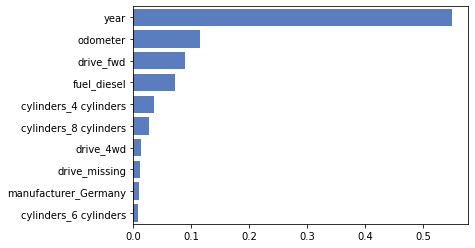

In [115]:
n=10
sns.barplot(x=features_importance[:n].values, y=features_importance[:n].index, color='b')
plt.show()


In [ ]:
# pipeline with grid search 
# param_grid = { }
# CV = GridSearchCV(clf, param_grid)
# CV.fit(X_train_raw, y_train)  
# print(CV.best_params_)    
# print(CV.best_score_)
